# Square deviations in different windows + channel summation
This program sums the signal from two or more channels.
Then computes the square deviations.
For each channel we obtain:

    * Plot of counts vs threshold for several voltages of scintillators
    * Plot of counts vs scintillator voltage for several values of threshold, and linear fits
    * Slope of the fits versus threshold

###### Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.cm as cm
import time
import os
os.chdir('..')
import csv
import scipy.stats as sct
import scipy.optimize as sco
from random import randrange
from collections import Counter
import microcodes_modules.functions as fc
from microcodes_modules.events import Event
from microcodes_modules.CAENReader import WDReader
from microcodes_modules.CAENReader import readChannels
from microcodes_modules.auto_plots import histo_stats
from collections import Counter

In [2]:
ch_colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown',
                  'tab:pink','tab:grey','tab:olive','tab:cyan']

In [3]:
colors1 = cm.hot(np.linspace(0,1,8))
colors2 = cm.gnuplot(np.linspace(0,1,30))

In [4]:
### SETTINGS ######################################################################################

###### Settings to read data (options IN)
""" Legend:
        * in_dir -> name of input directory
        * ADC_ch -> number of ADC channels, equal to 2^Nbits
        * nsamp -> number of samples per event
        * deltaT -> real time separation between two samples
        * Vpp -> voltage peak to peak
        * ngroups -> number of groups to study data
        * Nevents -> number of events per group
"""
in_dis  =     ['wavesh_211105_1146_70h10',
               'wavesh_211029_1300_92h00',
               'wavesh_211102_0955_47h43',
               'wavesh_211104_1102_23h00',
               'wavesh_211108_1029_0h38']
voltages=    [770,780,800,820,900]           # !!! voltages applied to scintillators
nbits   =    14                              # !!! number of bits for ADC channels
nsamp   =    1030                            # !!! number of samples per event
deltaT  =    4                               # !!! real time separation between two samples
Vpp     =    2.0                             # !!! voltage peak to peak
ADC_ch  =    2**nbits                        # number of ADC_channels, equal to 2**nbits
Fs      =    1/deltaT * 1e9                  # sampling frequency (Hz)
R       =    50                              # input impedance
ngroups =    1                               # number of groups to study data
Nevents =    'ind'                           # number of events per group
baseline=    ADC_ch//2                       # baseline

cntr_of_fwin = nsamp/2 # Here is the trigger
# Delays induced by the travel of signals by the cable from antennas to digitizer:
cable_delays = np.array([576.5,574.8,403.0,403.0,286.5,284.7,209.0,207.2]) # ns
# Time of particles from antennas height to floor (where scintillator is)
particle_delay = 30 #ns
# Approximated time of delay of trigger
trigger_delay = 30 #ns
# Total expected pulse delay = cable_delays - particle_delay - trigger_delay
total_delay = cable_delays - particle_delay - trigger_delay
print('Total delay for each channel: ', total_delay, '\n')

win = 200 # width of window in ns. Must be multiple of 4

Total delay for each channel:  [516.5 514.8 343.  343.  226.5 224.7 149.  147.2] 



In [5]:
min_delay = min(cable_delays)
min_tdelay = min(cable_delays) # !!! this determines the opening of the window when the channels are synchronized
print('Minimum delay: ', min_delay)
dif_delay = np.array([(item-min_delay) for item in cable_delays])
print('Differences of delays for each channel: ', dif_delay)
max_dif_delay = max(dif_delay)
print('Maximum delay diff: ', max_dif_delay)

Minimum delay:  207.2
Differences of delays for each channel:  [369.3 367.6 195.8 195.8  79.3  77.5   1.8   0. ]
Maximum delay diff:  369.3


In [6]:
baseline = ADC_ch//2
thresholds = [0,500,1000,1500,2000,2500,3000,3500,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500]

#### Synchronization of data

In [7]:
data = {} #
syn_data = {}

In [8]:
for i,in_dir in enumerate(in_dis):
    
    Volt = voltages[i]
    print('\n ===> '+str(Volt))
    READ = readChannels('DATA/'+in_dir,Vpp=2.0)
    DATA = READ.data()
    nevents = READ.nevents()
    print('Number of events:', nevents)
    file_list = READ.files_list()
    print(file_list)
    
    data[Volt] = {} #
    syn_data[Volt] = {}
    
    for wave in file_list:
        ich = int(wave[-5])
        
        data[Volt][ich] = {}
        syn_data[Volt][ich] = {}
        ##### SYNCHRONIZATION BY CABLE DELAYS #####
        syn_ini = int(dif_delay[ich]//deltaT)
        syn_fin = int(nsamp-(max_dif_delay//deltaT-syn_ini))
        
        for iev,event in DATA[ich].items():
            data[Volt][ich][iev] = event
            syn_data[Volt][ich][iev] = (event[0],event[1][syn_ini:syn_fin])


 ===> 770
file            wave0.dat   size       4086.7 KB
file            wave1.dat   size       4086.7 KB
file            wave2.dat   size       4086.7 KB
file            wave3.dat   size       4086.7 KB
file            wave4.dat   size       4086.7 KB
file            wave5.dat   size       4086.7 KB
file            wave6.dat   size       4086.7 KB
file            wave7.dat   size       4086.7 KB
 Reading file wave0.dat...
  INFO. Reading with header
 Reading file wave1.dat...
  INFO. Reading with header
 Reading file wave2.dat...
  INFO. Reading with header
 Reading file wave3.dat...
  INFO. Reading with header
 Reading file wave4.dat...
  INFO. Reading with header
 Reading file wave5.dat...
  INFO. Reading with header
 Reading file wave6.dat...
  INFO. Reading with header
 Reading file wave7.dat...
  INFO. Reading with header
 Working directory: /home/daniel/Documentos/HYBRID/Antenas
Number of events: 1961
['wave0.dat', 'wave1.dat', 'wave2.dat', 'wave3.dat', 'wave4.dat', 'wave5.da

## Summation of 2 channels

In [9]:
ch_sum = ['01','23','45','67']

In [10]:
sum_data2 = {}

In [11]:
for Volt in voltages:
    
    print('\n ===> '+str(Volt))
    
    sum_data2[Volt] = {}
    
    for group in ch_sum:
        
        sum_data2[Volt][group] = {}
        
        presel = 40 # ns
        ini = int(cntr_of_fwin) + int(min_tdelay/deltaT) - presel//deltaT #we assume a Hilbert pulse that begins when the signal arrives to antennas
        fin = ini + win//deltaT
        print(' Ch ', group)
        print('Index of start and end of window: ', ini,fin)
        print('Time of start and end of window:  ', ini*deltaT,fin*deltaT)
        
        Nevents = len(syn_data[Volt][0])
        nnsamp = len(syn_data[Volt][0][0][1])
        for iev in range(Nevents):
            time = syn_data[Volt][0][iev][0]
            sum_data2[Volt][group][iev] = (time,[])
            for isample in range(nnsamp):
                suma = 0
                i = 0
                for ch in group:
                    ich = int(ch)
                    suma += syn_data[Volt][ich][iev][1][isample]
                    i += 1
                sum_data2[Volt][group][iev][1].append(suma/i)


 ===> 770
 Ch  01
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
 Ch  23
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
 Ch  45
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
 Ch  67
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424

 ===> 780
 Ch  01
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
 Ch  23
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
 Ch  45
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
 Ch  67
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424

 ===> 800
 Ch  01
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
 Ch  23
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
 Ch  45

### Computing square deviations for 2 synchronized channels

In [12]:
stds_all   = {}
stds_sel   = {}
stds_nosel = {}
stds_diffs = {}

In [13]:
for Volt,Vdict in sum_data2.items():
    
    print('\n ===> '+str(Volt))
    
    stds_all[Volt] = {}
    stds_sel[Volt] = {}
    stds_nosel[Volt] = {}
    stds_diffs[Volt] = {}
    
    for group,gdict in Vdict.items():
        
        presel = 40 # ns
        ini = int(cntr_of_fwin) + int(min_tdelay//deltaT) - presel//deltaT #we assume a Hilbert pulse that begins when the signal arrives to antennas
        fin = ini + win//deltaT
        print(' Ch ', group)
        print('Index of start and end of window: ', ini,fin)
        print('Time of start and end of window:  ', ini*deltaT,fin*deltaT)
            
        all_all_values = []
        all_sel_values = []
        all_nosel_values = []
        for iev,event in gdict.items():
            all_all_values += event[1]
            all_sel_values += event[1][ini:fin]
            all_nosel_values += event[1][:ini] + event[1][fin:]
        print('control1')
        
        mean_all   = np.mean(all_all_values)
        
        all_std = fc.sqdev(all_all_values,mean_all)
        sel_std = fc.sqdev(all_sel_values,mean_all)
        nosel_std = fc.sqdev(all_nosel_values,mean_all)
        
        stds_all[Volt][group] = all_std
        stds_sel[Volt][group] = sel_std
        stds_nosel[Volt][group] = nosel_std
        stds_diffs[Volt][group] = sel_std - nosel_std


 ===> 770
 Ch  01
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
control1
 Ch  23
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
control1
 Ch  45
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
control1
 Ch  67
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
control1

 ===> 780
 Ch  01
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
control1
 Ch  23
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
control1
 Ch  45
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
control1
 Ch  67
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
control1

 ===> 800
 Ch  01
Index of start and end of window:  556 606
Time of start and end of window:   2224 2424
control1
 Ch  23
Index of start

### Plots

#### Counts versus scintillator voltage

In [14]:
def recta(x,a,b):
    return a*x + b

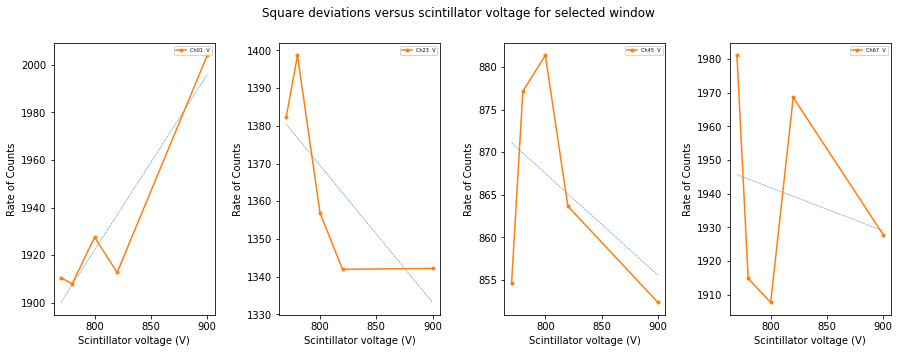

In [15]:
fig1 = plt.figure(1,figsize=(15,5))
fig1.suptitle('Square deviations versus scintillator voltage for selected window')
fig1.subplots_adjust(hspace=0.2,wspace=0.4)

fit_params_sel = {}
fit_params2_sel = {}
for i,group in enumerate(ch_sum):
    fit_params_sel[group] = {}
    fit_params2_sel[group] = {}
    ax1 = fig1.add_subplot(1,4,i+1)

    x = [] ;  y = []
    for Volt in voltages:
        x.append(Volt)
        y.append(stds_sel[Volt][group])
        
    # (1) Fit to all points:
    if not all([item == y[0] for item in y]):
        popt, pcov = sco.curve_fit(recta,x,y)
        a,b = popt
        fit_params_sel[group]['a'] = a
        fit_params_sel[group]['b'] = b
        fit_result = recta(np.array(voltages),a,b)
        chisq = sum([(yi-fiti)**2/fiti for (yi,fiti) in zip(y,fit_result)])
        fit_params_sel[group]['chi2'] = chisq
        ax1.plot(voltages,fit_result,linewidth=0.5,linestyle='--')
        
    #chi_str = (' %5.1e %5.1e' %(chisq,chisq2))
    ax1.plot(x,y,'.-',label='Ch'+group+' '+' V') #+' '+chi_str)
    ax1.set_xlabel('Scintillator voltage (V)')
    ax1.set_ylabel('Rate of Counts')
    #ax1.set_xlim(thresholds[0],thresholds[-1])
    #ax1.set_ylim(0,1)
    #ax1.grid()
    ax1.legend(prop={'size':5})
    #time.sleep(1)
#plt.show()

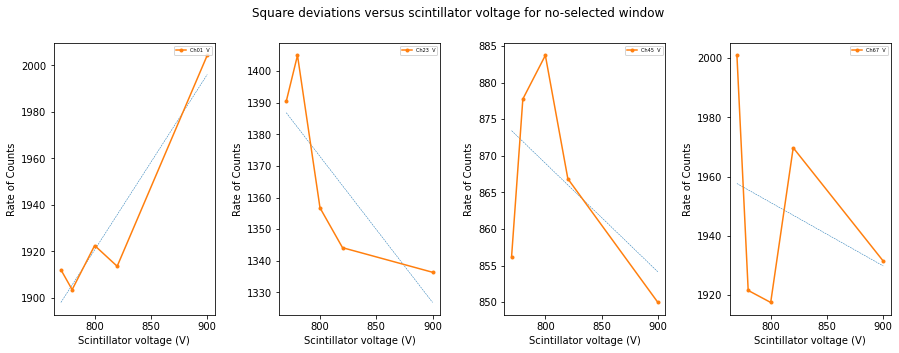

In [16]:
fig2 = plt.figure(3,figsize=(15,5))
fig2.suptitle('Square deviations versus scintillator voltage for no-selected window')
fig2.subplots_adjust(hspace=0.2,wspace=0.4)

fit_params_sel = {}
fit_params2_sel = {}
for i,group in enumerate(ch_sum):
    fit_params_sel[group] = {}
    fit_params2_sel[group] = {}
    ax2 = fig2.add_subplot(1,4,i+1)

    x = [] ;  y = []
    for Volt in voltages:
        x.append(Volt)
        y.append(stds_nosel[Volt][group])
        
    # (1) Fit to all points:
    if not all([item == y[0] for item in y]):
        popt, pcov = sco.curve_fit(recta,x,y)
        a,b = popt
        fit_params_sel[group]['a'] = a
        fit_params_sel[group]['b'] = b
        fit_result = recta(np.array(voltages),a,b)
        chisq = sum([(yi-fiti)**2/fiti for (yi,fiti) in zip(y,fit_result)])
        fit_params_sel[group]['chi2'] = chisq
        ax2.plot(voltages,fit_result,linewidth=0.5,linestyle='--')
        
    #chi_str = (' %5.1e %5.1e' %(chisq,chisq2))
    ax2.plot(x,y,'.-',label='Ch'+group+' '+' V') #+' '+chi_str)
    ax2.set_xlabel('Scintillator voltage (V)')
    ax2.set_ylabel('Rate of Counts')
    #ax2.set_xlim(thresholds[0],thresholds[-1])
    #ax2.set_ylim(0,1)
    #ax2.grid()
    ax2.legend(prop={'size':5})
    #time.sleep(1)
#plt.show()

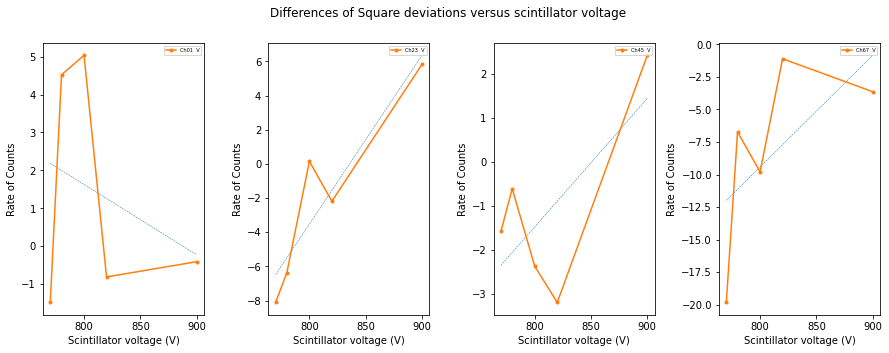

In [17]:
fig3 = plt.figure(3,figsize=(15,5))
fig3.suptitle('Differences of Square deviations versus scintillator voltage')
fig3.subplots_adjust(hspace=0.2,wspace=0.4)

fit_params_sel = {}
fit_params2_sel = {}
for i,group in enumerate(ch_sum):
    fit_params_sel[group] = {}
    fit_params2_sel[group] = {}
    ax3 = fig3.add_subplot(1,4,i+1)

    x = [] ;  y = []
    for Volt in voltages:
        x.append(Volt)
        y.append(stds_diffs[Volt][group])
        
    # (1) Fit to all points:
    if not all([item == y[0] for item in y]):
        popt, pcov = sco.curve_fit(recta,x,y)
        a,b = popt
        fit_params_sel[group]['a'] = a
        fit_params_sel[group]['b'] = b
        fit_result = recta(np.array(voltages),a,b)
        chisq = sum([(yi-fiti)**2/fiti for (yi,fiti) in zip(y,fit_result)])
        fit_params_sel[group]['chi2'] = chisq
        ax3.plot(voltages,fit_result,linewidth=0.5,linestyle='--')
        
    #chi_str = (' %5.1e %5.1e' %(chisq,chisq2))
    ax3.plot(x,y,'.-',label='Ch'+group+' '+' V') #+' '+chi_str)
    ax3.set_xlabel('Scintillator voltage (V)')
    ax3.set_ylabel('Rate of Counts')
    #ax3.set_xlim(thresholds[0],thresholds[-1])
    #ax3.set_ylim(0,1)
    #ax3.grid()
    ax3.legend(prop={'size':5})
    #time.sleep(1)
#plt.show()